In [2]:
library(sits)
library(sitsdata)
library(dplyr)
library(ggplot2)
library(plotly)
library(stars)
library(leaflet)

In [3]:
read_file <- function(file, ext) {
  data.tb <- NULL
  if (ext == "csv") {
    data.tb <- read.csv(file)
  }
  if (ext == "rds") {
    data.tb <- readRDS(file)
  }
  if (ext == "rda") {
    data.tb <- get(load(file))
  }
  return(data.tb)
}

In [4]:
point_to_shape_sp <- function (data.tb, class_label) {
  group_shape <- dplyr::select(data.tb,
    longitude, latitude,
    start_date, end_date,
    label #, cube
  )
  sp_data.tb.df <- as.data.frame(group_shape)
  sp_data.tb.df <- sp_data.tb.df %>% filter(label == class_label)
  points_SF <- as.data.frame(sp_data.tb.df)
  xy <- points_SF[, c(1, 2)]
  sp_data.df <- sp::SpatialPointsDataFrame(
    coords = xy,
    data = points_SF,
    proj4string = sp::CRS("+proj=longlat +datum=WGS84 +ellps=WGS84 +towgs84=0,0,0")
  )
  return(sp_data.df)
}

In [5]:
as_sample <- function(data.tb) {
    data.tb <- as.data.frame(data.tb)
#     data.tb <- dplyr::select(data.tb, -cube)
#     data.tb <- dplyr::mutate(data.tb, cube = coverage, .after = 5)
#     data.tb <- dplyr::select(data.tb, -coverage, -time_series)
#     data.tb <- dplyr::select(data.tb, -time_series)
    return(data.tb)
}

In [6]:
save_file <- function(data.tb, name) {
#     write.csv(data.tb, paste("./data/", name, ".csv", sep=""), row.names = FALSE)
    save(data.tb, file = paste("./data/", name, ".rda", sep=""))
}

In [65]:
file_name <- "./data/samples_sinop_crop.csv"
ext <- "csv"

In [66]:
input_data.tb <- read_file(file_name, ext)
input_data.tb <- as_sample(input_data.tb)
head(input_data.tb, 5)

,id,longitude,latitude,start_date,end_date,label
,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,-55.65931,-11.76267,2013-09-14,2014-08-29,Pasture
2,2,-55.64833,-11.76385,2013-09-14,2014-08-29,Pasture
3,3,-55.66738,-11.78032,2013-09-14,2014-08-29,Forest
4,4,-55.64747,-11.75276,2013-09-14,2014-08-29,Pasture
5,5,-55.65742,-11.78788,2013-09-14,2014-08-29,Forest


In [67]:
group <- dplyr::group_by(input_data.tb, label)
agregation <- dplyr::summarise(group, n = n(), .groups = "drop_last")
mutation <- dplyr::mutate(agregation, percent = n/sum(n))
mutation <- data.frame(mutation)
mutation

label,n,percent
<chr>,<int>,<dbl>
Cerrado,3,0.1666667
Forest,3,0.1666667
Pasture,4,0.2222222
Soy_Corn,8,0.4444444


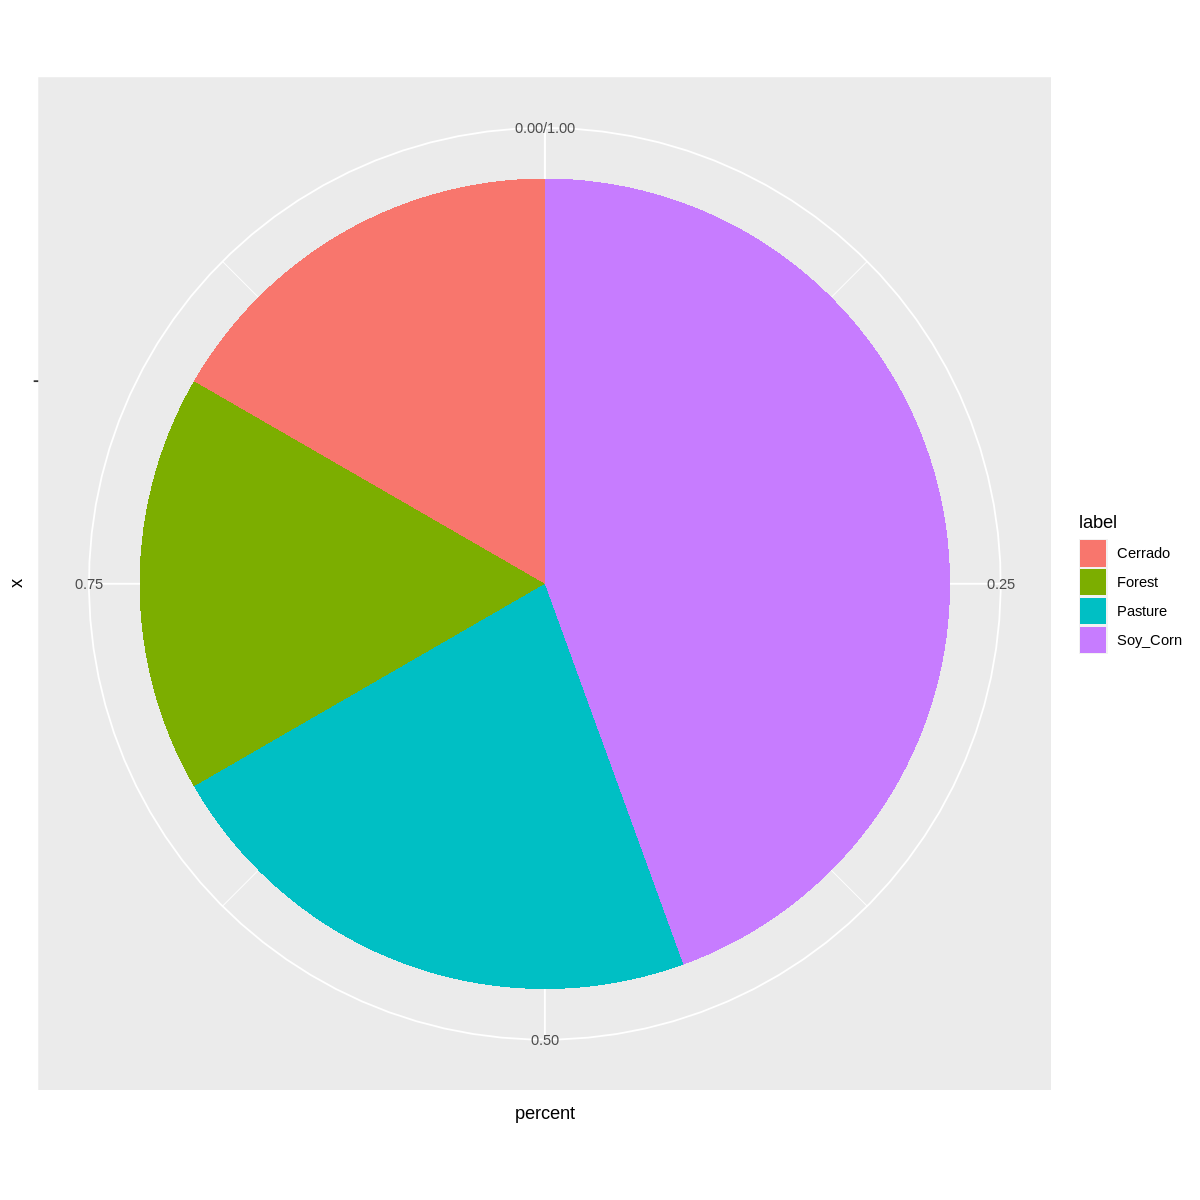

In [68]:
# Configure plot size 
options(repr.plot.width = 10, repr.plot.height = 10)
ggplot(
    mutation,
    aes(x="", y=percent, fill=label)
) + geom_bar(width = 1, stat = "identity") + coord_polar("y", start=0)

In [69]:
shape <- point_to_shape_sp(
    data.tb = input_data.tb,
    class_label = "Soy_Corn"
)
leaflet(shape, options = leafletOptions(minZoom = 0, maxZoom = 100)) %>%
        addTiles() %>%
            addMarkers(
                ~longitude, ~latitude,
                popup = ~as.character(
                    paste("Class '", label, "' |",
                        format(
                            as.Date(start_date),
                            format = "Start %Y-%m-%d"
                        ),
                        format(
                            as.Date(end_date),
                            format = "End %Y-%m-%d"
                        )
                    )))

HTML widgets cannot be represented in plain text (need html)

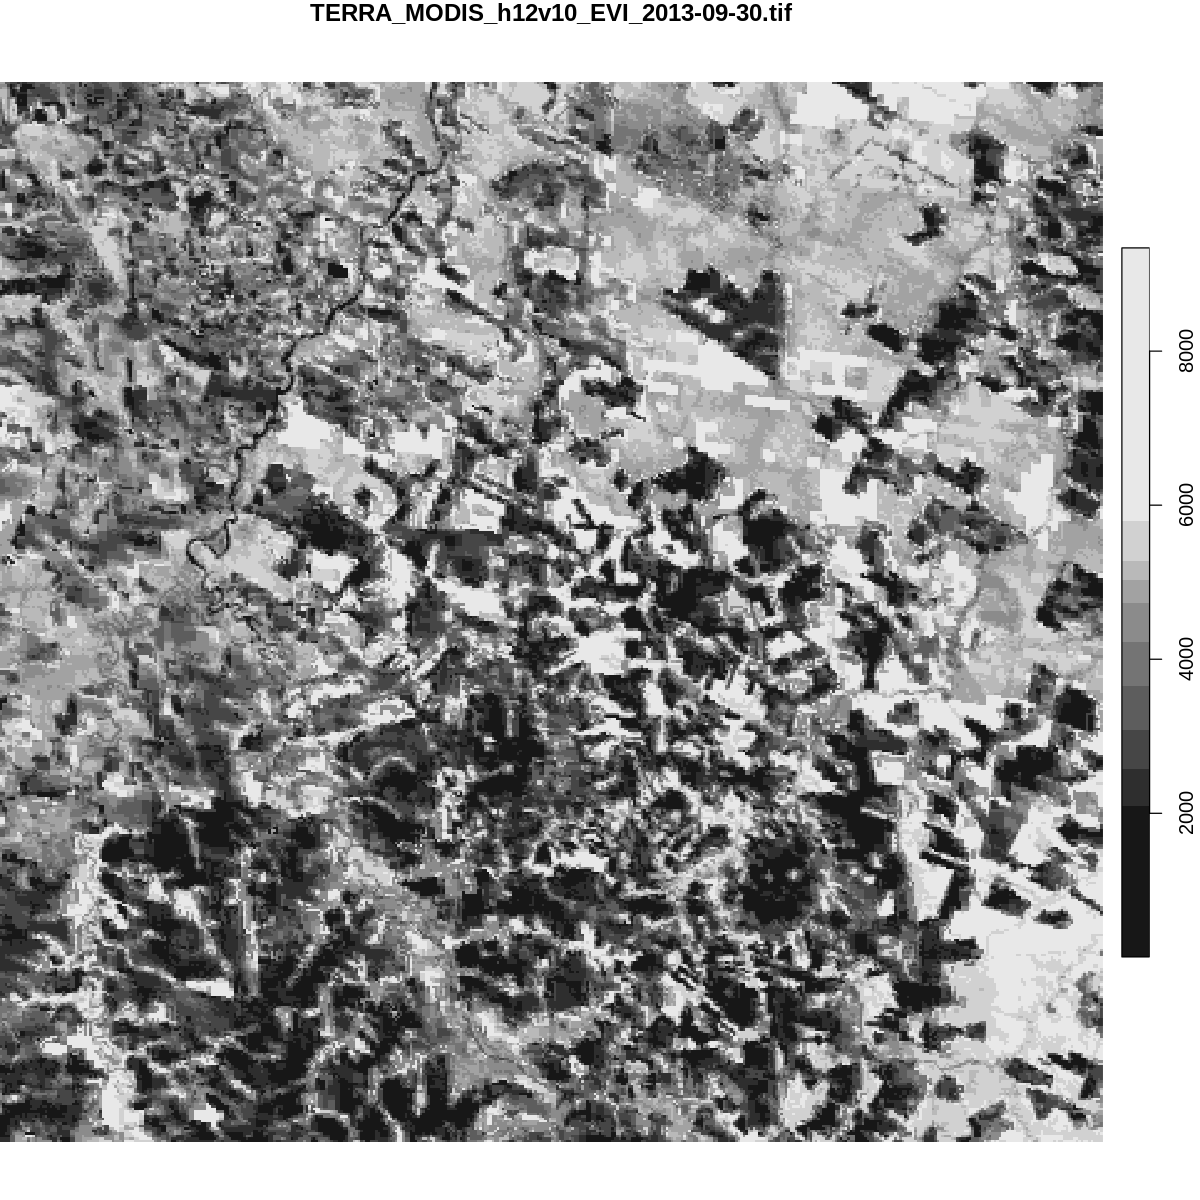

In [73]:
data_dir <- system.file("extdata/sinop", package = "sitsdata")
raster_cube <- sits_cube(
        source = "LOCAL",
        name = "sinop-2014",
        satellite = "TERRA",
        sensor = "MODIS",
        data_dir = data_dir
)
options(repr.plot.width = 10, repr.plot.height = 10)
plot(raster_cube, band = "EVI", time = 2)

In [75]:
points <- sits_get_data(raster_cube, file = file_name)
head(points, 1)

All points have been retrieved



longitude,latitude,start_date,end_date,label,cube,time_series
<dbl>,<dbl>,<date>,<date>,<chr>,<chr>,<list>
-55.65931,-11.76267,2013-09-14,2014-08-29,Pasture,sinop-2014,"15962.0000, 15978.0000, 15994.0000, 16010.0000, 16026.0000, 16042.0000, 16058.0000, 16071.0000, 16087.0000, 16103.0000, 16119.0000, 16135.0000, 16151.0000, 16167.0000, 16183.0000, 16199.0000, 16215.0000, 16231.0000, 16247.0000, 16263.0000, 16279.0000, 16295.0000, 16311.0000, 0.2106, 0.3169, 0.2674, 0.3430, 0.3897, 0.4803, 0.5254, 0.5254, 0.4680, 0.4708, 0.1790, 0.3151, 0.4756, 0.4006, 0.4509, 0.4284, 0.3551, 0.3730, 0.3146, 0.2480, 0.1967, 0.1883, 0.2211, 0.3386, 0.4327, 0.4608, 0.5664, 0.4799, 0.5867, 0.6543, 0.6543, 0.6912, 0.6439, 0.1721, 0.7537, 0.7299, 0.6144, 0.6653, 0.6510, 0.5940, 0.6135, 0.5229, 0.4271, 0.3451, 0.3182, 0.3272"


In [88]:
head(tibble(points$time_series[[1]]), 3)

Index,EVI,NDVI
<date>,<dbl>,<dbl>
2013-09-14,0.2106,0.3386
2013-09-30,0.3169,0.4327
2013-10-16,0.2674,0.4608


In [110]:
points[3,]

longitude,latitude,start_date,end_date,label,cube,time_series
<dbl>,<dbl>,<date>,<date>,<chr>,<chr>,<list>
-55.66738,-11.78032,2013-09-14,2014-08-29,Forest,sinop-2014,"15962.0000, 15978.0000, 15994.0000, 16010.0000, 16026.0000, 16042.0000, 16058.0000, 16071.0000, 16087.0000, 16103.0000, 16119.0000, 16135.0000, 16151.0000, 16167.0000, 16183.0000, 16199.0000, 16215.0000, 16231.0000, 16247.0000, 16263.0000, 16279.0000, 16295.0000, 16311.0000, 0.5536, 0.4968, 0.5135, 0.4770, 0.5706, 0.5779, 0.6282, 0.6282, 0.4847, 0.4121, 0.1624, 0.4525, 0.3854, 0.4338, 0.4575, 0.4302, 0.4053, 0.4036, 0.4098, 0.3976, 0.4292, 0.4671, 0.5526, 0.8204, 0.8025, 0.8601, 0.8928, 0.7993, 0.8830, 0.8442, 0.8442, 0.8314, 0.7653, 0.1876, 0.8417, 0.8159, 0.8936, 0.8430, 0.8233, 0.8315, 0.8170, 0.8280, 0.8152, 0.8042, 0.8297, 0.8163"


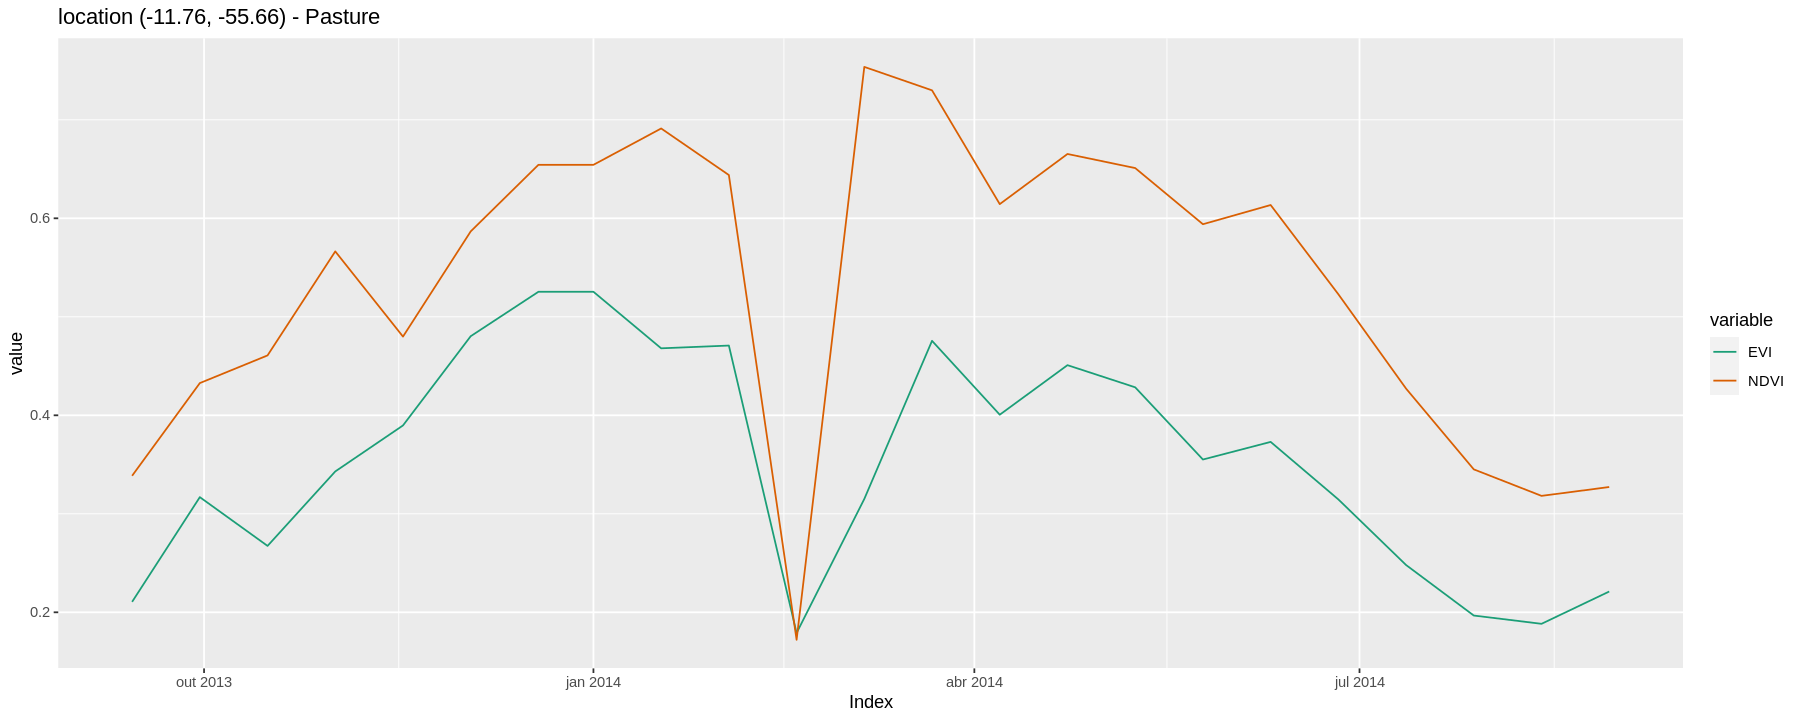

In [107]:
options(repr.plot.width = 15, repr.plot.height = 6)
filtered <- dplyr::filter(points, label == "Soy_Corn")
plot(points[1,])

In [119]:
save_file(points, "samples_sinop_response_sits")

In [95]:
wtss_inpe <- "https://brazildatacube.dpi.inpe.br/wtss/"
Rwtss::list_coverages(wtss_inpe)

[1] "MOD13Q1-6"               "MYD13Q1-6"              
 [3] "S2_10_16D_STK-1"         "S2-SEN2COR_10_16D_STK-1"
 [5] "S2_10-1"                 "CB4MUX_20-1"            
 [7] "CB4MUX_20_1M_STK-1"      "LC8_30-1"               
 [9] "LC8_30_16D_STK-1"        "CB4_20_1M_STK-1"        
[11] "LC8_30_6M_MEDSTK-1"      "CB4_64_16D_STK-1"       
[13] "CB4_64-1"                "LANDSAT-MOZ_30_1M_STK-1"

In [96]:
coverage <- "MOD13Q1-6"
desc <- Rwtss::describe_coverage(wtss_inpe, name = coverage)
desc$bands

---------------------------------------------------------------------
WTSS server URL = https://brazildatacube.dpi.inpe.br/wtss
Cube (coverage) = MOD13Q1-6

|satellite|sensor|bands                                                                                                                                                                                                                                                                                                                             |
|:--------|:-----|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|TERRA    |MODIS |view_zenith_angle        , sun_zenith_angle         , pixel_reliability        , relative_azimuth_angle   , blue_reflectance         , red_re

[[1]]
 [1] "view_zenith_angle"         "sun_zenith_angle"         
 [3] "pixel_reliability"         "relative_azimuth_angle"   
 [5] "blue_reflectance"          "red_reflectance"          
 [7] "NIR_reflectance"           "MIR_reflectance"          
 [9] "NDVI"                      "EVI"                      
[11] "VI_Quality"                "composite_day_of_the_year"

In [97]:
sample <- data.frame(head(input_data.tb, 1))
start <- sample$start_date
end <- sample$end_date
lat <- sample$latitude
long <- sample$longitude
bands <- c('NDVI', 'EVI', 'NIR_reflectance')

In [98]:
response = Rwtss::time_series(
    wtss_inpe, 
    name = coverage, 
    attributes = bands, 
    longitude = long,
    latitude  = lat,
    start_date = start, 
    end_date = end,
    token = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV"
)
cube <- response$cube
ts <- data.frame(response$time_series)
head(ts, 3)

,Index,NDVI,EVI,NIR_reflectance
,<date>,<dbl>,<dbl>,<dbl>
1,2013-09-14,0.3532,0.2201,0.3063
2,2013-09-30,0.4216,0.2693,0.3370
3,2013-10-16,0.4831,0.2732,0.2680


In [99]:
sample

,id,longitude,latitude,start_date,end_date,label
,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,1,-55.65931,-11.76267,2013-09-14,2014-08-29,Pasture


In [100]:
response <- dplyr::select(response, -label)
response <- dplyr::mutate(response, label = sample$label, .after = 4)
response

longitude,latitude,start_date,end_date,label,cube,time_series
<dbl>,<dbl>,<date>,<date>,<chr>,<chr>,<list>
-55.65931,-11.76267,2013-09-14,2014-08-29,Pasture,MOD13Q1-6,"15962.0000, 15978.0000, 15994.0000, 16010.0000, 16026.0000, 16042.0000, 16058.0000, 16071.0000, 16087.0000, 16103.0000, 16119.0000, 16135.0000, 16151.0000, 16167.0000, 16183.0000, 16199.0000, 16215.0000, 16231.0000, 16247.0000, 16263.0000, 16279.0000, 16295.0000, 16311.0000, 0.3532, 0.4216, 0.4831, 0.5480, 0.4112, 0.6175, 0.6641, 0.6641, 0.6982, 0.6705, 0.1667, 0.2757, 0.4343, 0.6587, 0.6738, 0.6622, 0.5940, 0.6099, 0.5259, 0.4098, 0.3575, 0.3153, 0.3261, 0.2201, 0.2693, 0.2732, 0.3043, 0.3717, 0.4933, 0.5487, 0.5487, 0.4909, 0.4983, 0.1777, 0.3125, 0.4216, 0.4547, 0.4689, 0.4521, 0.3707, 0.3862, 0.3270, 0.2519, 0.2131, 0.1838, 0.2002, 0.3063, 0.3370, 0.2680, 0.2620, 0.4712, 0.3798, 0.4727, 0.4727, 0.3681, 0.3534, 0.4338, 0.5070, 0.4552, 0.3529, 0.3664, 0.3485, 0.3039, 0.3108, 0.2981, 0.3048, 0.2707, 0.2918, 0.2903"


In [101]:
sits_select(response, "NDVI")

Warning message:
“Unknown or uninitialised column: `source`.”


ERROR: Error: .sits_config_data_meta_type: data is not valid


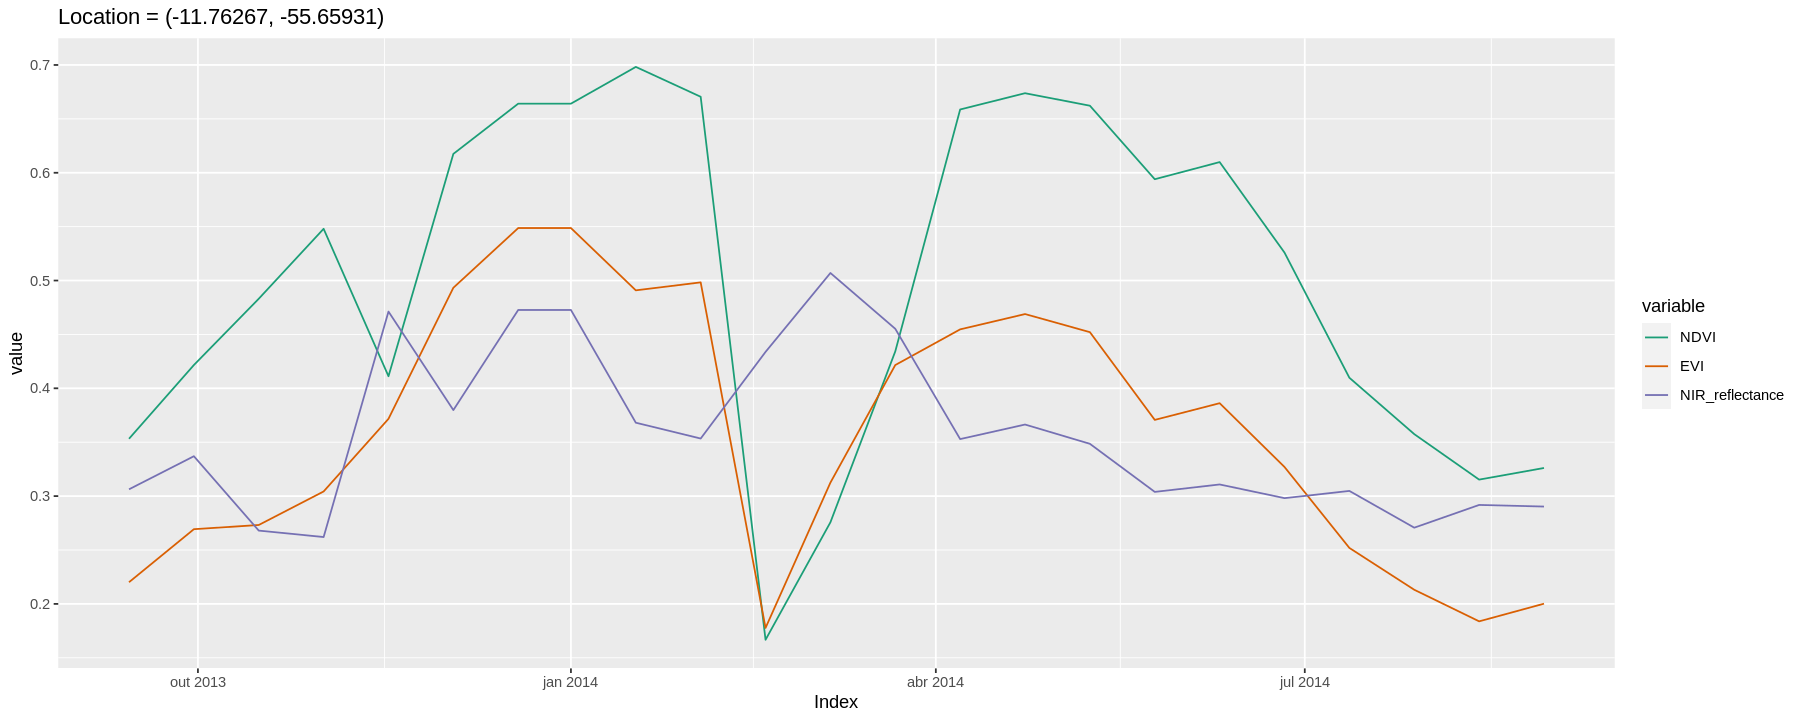

In [102]:
# Configure plot size 
options(repr.plot.width = 15, repr.plot.height = 6)
plot(response)